# FBRESNET - one example

In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

### Initialisation
The condition are as follows:
$a=1$ ,
$p=1$ ,
the constraint is $0 <x_i <1$ .

In [4]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,0.5,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=True
    )

### Dataset

In [5]:
train_set, val_set = model.CreateDataSet()

### Trainings
The training is done over 20 epochs, learning rate is $10^{-3}$.
The Lipschitz constant is plot duroing training.
Here the parameter can be saved after training in file 'Trainings', and uploaded later. (1 hour)

In [6]:
model.train(train_set,val_set)

epoch :  0  -----  training :  0.0316    validation :  0.0292
epoch :  1  -----  training :  0.0297    validation :  0.0275
epoch :  2  -----  training :  0.0279    validation :  0.0258
epoch :  3  -----  training :  0.0262    validation :  0.0243
epoch :  4  -----  training :  0.0246    validation :  0.0228
epoch :  5  -----  training :  0.0231    validation :  0.0214
epoch :  6  -----  training :  0.0217    validation :  0.0201
epoch :  7  -----  training :  0.0204    validation :  0.0190
epoch :  8  -----  training :  0.0192    validation :  0.0178
epoch :  9  -----  training :  0.0180    validation :  0.0168
epoch : 10  -----  training :  0.0170    validation :  0.0158
epoch : 11  -----  training :  0.0160    validation :  0.0149
epoch : 12  -----  training :  0.0151    validation :  0.0141
epoch : 13  -----  training :  0.0142    validation :  0.0133
epoch : 14  -----  training :  0.0134    validation :  0.0125
epoch : 15  -----  training :  0.0127    validation :  0.0119
epoch : 

# Test the model

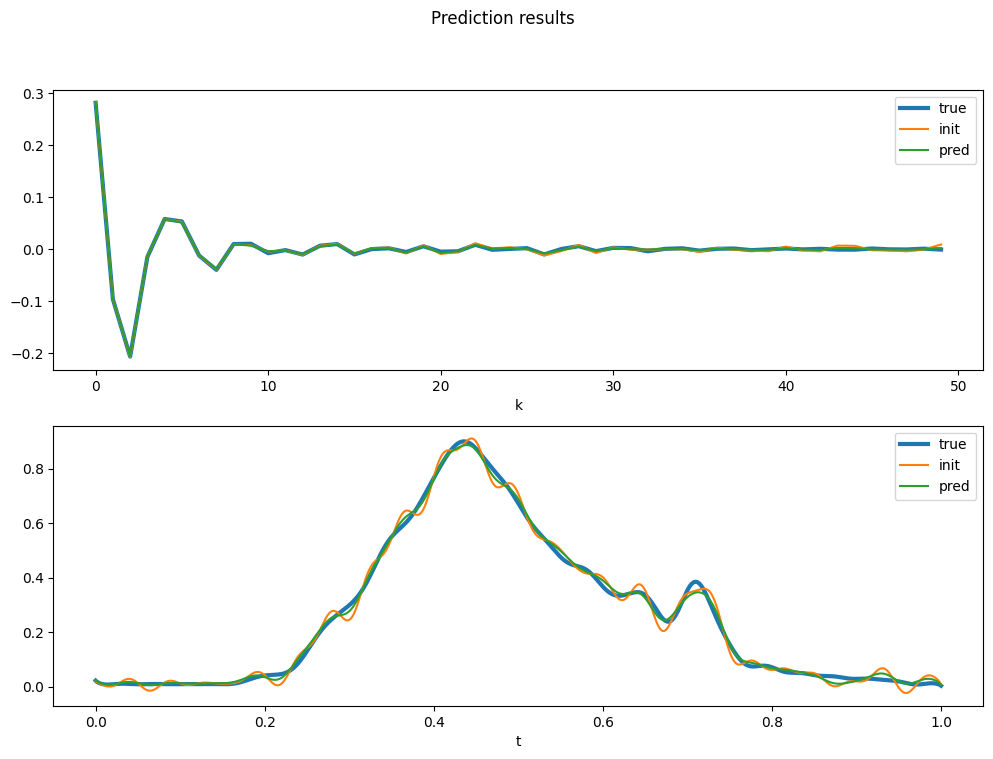

Erreur de sortie :  0.0034227988217025995
Erreur initiale :  0.00233467691577971


In [7]:
loss, signals = model.test(val_set,plot_opt=True)

### Test on a Gaussian function

<class 'str'>


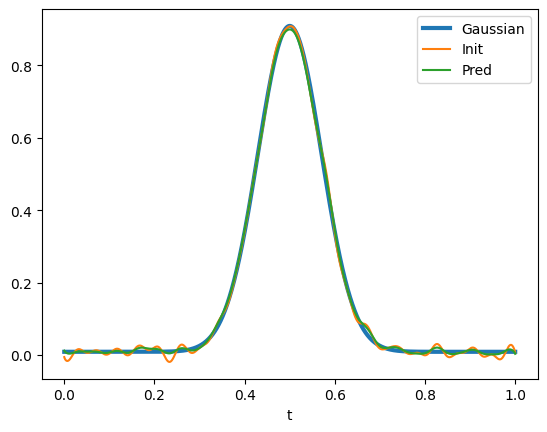

|x-xp|/|x| =  0.0004139419066875734


In [17]:
model.test_gauss()

### Lipschitz constant

Here we implement for the Gaussian signal the lipschitz constant of the neural network, depending on the input. s or if 

$x_{in}=x_{bias}=T_a^T y^\delta$ 

In [18]:
model.model.Lipschitz(opt1="semi",opt2="entree11")

0.051240329968287555

$x_{in}= 0$, and $x_{bias}= T_a^T y^\delta$ 

In [19]:
model.model.Lipschitz(opt1="semi",opt2="entree01")

0.00510661575765254

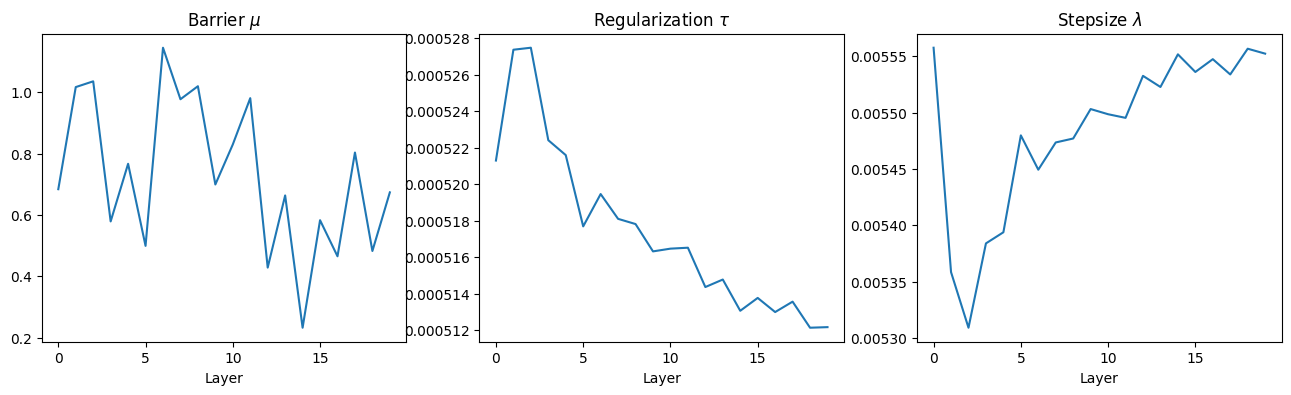

In [20]:
mu_vec = [np.squeeze(model.model.Layers[layer_id].mu).item() for layer_id in range(20)]
tau_vec = [np.squeeze(model.model.Layers[layer_id].gamma_reg[1]).item() for layer_id in range(20)]
lambda_vec = [np.squeeze(model.model.Layers[layer_id].gamma_reg[0]).item() for layer_id in range(20)]

im, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(mu_vec)
ax[0].set_xlabel('Layer')
ax[0].set_title(r'Barrier $\mu$')

ax[1].plot(tau_vec)
ax[1].set_xlabel('Layer')
ax[1].set_title(r'Regularization $\tau$')

ax[2].plot(lambda_vec)
ax[2].set_xlabel('Layer')
ax[2].set_title(r'Stepsize $\lambda$')
plt.show()


In [21]:
opt_hist = np.load('../outputs/opt_hist/model_000_opt_hist.npy', allow_pickle=True)[()]
opt_hist.keys()

dict_keys(['lipschitz', 'loss_train', 'loss_val', 'fb_params'])

In [22]:
hyper_params = opt_hist['fb_params']

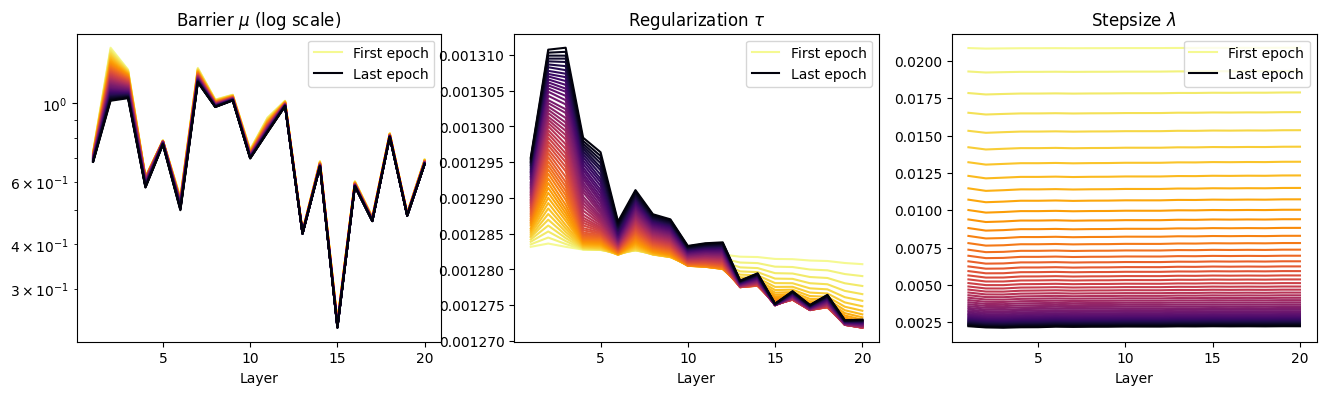

In [23]:
im, ax = plt.subplots(1,3, figsize=(16,4))
for i in range(model.nb_epochs):

    ax[0].plot(np.arange(1, model.nb_blocks+1),hyper_params[i,0], color=sns.color_palette('inferno',n_colors=model.nb_epochs)[model.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(model.nb_epochs-1) else '_hide')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Layer')
    ax[0].set_title(r'Barrier $\mu$ (log scale)')

    ax[1].plot(np.arange(1, model.nb_blocks+1),hyper_params[i,1], color=sns.color_palette('inferno',n_colors=model.nb_epochs)[model.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(model.nb_epochs-1) else '_hide')
    ax[1].set_xlabel('Layer')
    ax[1].set_title(r'Regularization $\tau$')

    ax[2].plot(np.arange(1, model.nb_blocks+1),hyper_params[i,2], color=sns.color_palette('inferno',n_colors=model.nb_epochs)[model.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(model.nb_epochs-1) else '_hide')
    ax[2].set_xlabel('Layer')
    ax[2].set_title(r'Stepsize $\lambda$')

for i in range(3): ax[i].legend()
plt.show()

In [24]:
opt_hist['lipschitz'].shape

(50,)

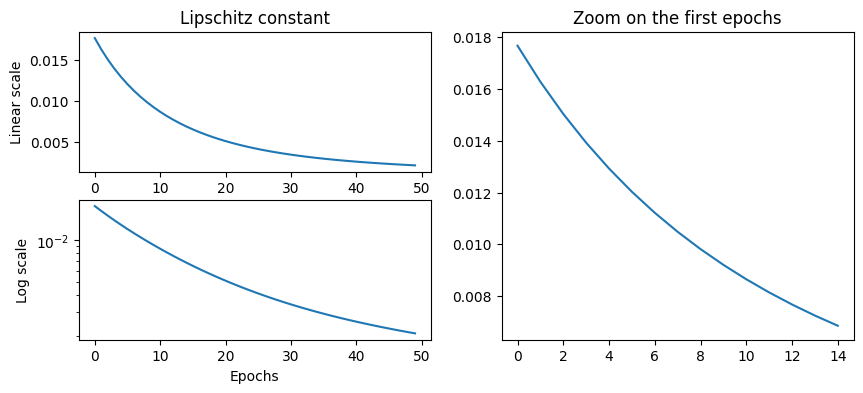

In [25]:
lip_cte = opt_hist['lipschitz']

fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(2,2,1)
ax.plot(lip_cte)
ax.set_ylabel('Linear scale')
ax.set_title('Lipschitz constant')
#ax.set_xticks(np.arange(1,exp1.nb_epochs+1,3))

ax = fig.add_subplot(2,2,3)
ax.plot(lip_cte)
ax.set_xlabel('Epochs')
ax.set_ylabel('Log scale')
ax.set_yscale('log')
#ax.set_xticks(np.arange(1,exp1.nb_epochs+1,3))

ax = fig.add_subplot(2,2,(2,4))
ax.plot(lip_cte[:15])
ax.set_title('Zoom on the first epochs')
#ax.set_xticks(np.arange(1,16,3))

plt.show()